<img src="https://raw.githubusercontent.com/alan-barzilay/NLPortugues/master/imagens/logo_nlportugues.png"   width="150" align="right">

# EP 1: RNNs Bidirecionais, Overfitting, Underfitting

#### MAC5725 - Linguística Computacional

______________

## <font color='3474eb'> Preparação do ambiente </font>







### Importa as bibliotecas necessárias



In [10]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
tf.__version__

'2.13.0'

### Define parâmetros usados pelo programa


In [12]:
SEED = 347920

# Caminho para download do corpus B2W
B2W_CORPUS_SRC = "https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/main/B2W-Reviews01.csv"
B2W_CORPUS_DEST = "data/b2w-full.csv"

# Proporção de treino, validação e teste.
TRAIN_SIZE = 0.75
VALIDATION_SIZE = 0.10
TEST_SIZE = 0.15

# Caminho para os arquivos de treino, validação e teste.
TRAIN_CSV = "data/b2w_train.csv"
VALIDATION_CSV = "data/b2w_validation.csv"
TEST_CSV = "data/b2w_test.csv"

# Tamanho das sentenças.
BATCH_SIZE = 64

# Habilita balanceamento dos dados.
BALANCE_ENABLED = True

# Tamanho do vocabulário para vetorização (max_tokens).
VOCAB_SIZE = 600

### Importando os dados como um dataframe

Utilizaremos o dataset **B2W-Reviews01**, que contém cerca de 130k avaliações de produtos de uma plataforma de comércio eletrônico. Disponível [neste link](https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/main/B2W-Reviews01.csv).


In [13]:
# Cria pasta de destino
!mkdir -p data

# Dataset completo
!curl {B2W_CORPUS_SRC} --output {B2W_CORPUS_DEST}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47.1M  100 47.1M    0     0  67.1M      0 --:--:-- --:--:-- --:--:-- 67.1M


## <font color='3474eb'> Pré-processamento </font>

Nesta etapa os dados são extraídos do arquivo csv, em seguida, são gerados os conjuntos de treinamento, validação e teste, e por fim, as palavras são codificadas de maneira vetorizada.

In [14]:
def filter_data(b2w_corpus):
    '''
    Recebe o corpus (DataFrame pandas), seleciona as colunas contendo o texto e
    a nota de avaliação, e no fim, remove as linhas que não possuem rótulo
    com valor entre 1 e 5.

    Caso a flag BALANCE_ENABLED esteja habilitada, a base será subamostrada para
    ter o mesmo tamanho de amostras em todas as classes (com base na classe
    com menos amostras).
    '''

    # Seleciona e renomeia colunas.
    b2w_filtered = b2w_corpus.loc[:, ['review_text', 'overall_rating']]
    b2w_filtered.rename(
        columns={'review_text': 'texto', 'overall_rating': 'rotulo'},
        inplace = True)

    # Descarta linhas com dados nulos.
    b2w_filtered = b2w_filtered.dropna()

    # Seleciona linhas com rótulos válidos.
    b2w_filtered = b2w_filtered.loc[
        ((b2w_filtered['rotulo'] >= 1) & (b2w_filtered['rotulo'] <= 5))]

    # Ajusta rótulos.
    b2w_filtered['rotulo'].replace(
        [1, 2, 3, 4, 5], [0, 1, 2, 3, 4], inplace=True)

    # Balanceia os dados usando uma subamostragem do tamanho da menor classe.
    if BALANCE_ENABLED:
        grp = b2w_filtered.groupby('rotulo')
        b2w_filtered = grp.apply(lambda x: x.sample(grp.size().min()).reset_index(drop=True))

    return b2w_filtered

def split_data(csv_input_path):
    '''
    Carrega os dados do arquivo de entrada, filtra os dados, particiona os dados
    para treinamento, validação e teste. Salva os dados em arquivos e retorna os
    dados como saída.
    '''

    # Carrega arquivo CSV.
    b2w_corpus = pd.read_csv(csv_input_path)

    # Filtra dados.
    b2w_filtered = filter_data(b2w_corpus)
    print('\nCorpus B2w - filtrado:\n')
    print(b2w_filtered.info())

    # Divide a base em conjuntos de treinamento, validação e teste.
    pos_1 = int(TRAIN_SIZE * len(b2w_filtered))
    pos_2 = int((TRAIN_SIZE + VALIDATION_SIZE) * len(b2w_filtered))
    train, validation, test = np.split(
        b2w_filtered.sample(frac=1, random_state=SEED), # amostra pseudo-aleatória do dataframe, frac=1 => 100%
        [pos_1, pos_2])                                 # divide em 3 partições, equivalentes a [0:pos_1], [pos_1:pos_2], [pos_2:end]

    # Salva arquivos de treino, validação e teste
    train.to_csv(TRAIN_CSV)
    validation.to_csv(VALIDATION_CSV)
    test.to_csv(TEST_CSV)

    return train, validation, test

def encode_data(sentences_vector):
    '''
    Prepara a camada de tokenização e de embeddings para codificar o texto.

    O vocabulário completo possui cerca de 12k palavras, mas usamos VOCAB_SIZE
    para limitar o número de tokens. Em geral, números na ordem de 500 - 2k
    apresentaram melhores resultados.

    Um padding é adicionado se a sentença tiver comprimento menor que
    BATCH_SIZE. Se o comprimento for maior, a sentença é truncada.
    '''

    # Define a camada de tokenização.
    vectorize_layer = tf.keras.layers.TextVectorization(
        max_tokens=VOCAB_SIZE,
        output_sequence_length=BATCH_SIZE,
    )
    vectorize_layer.adapt(sentences_vector)

    embedding_layer = tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE, output_dim=128)

    return vectorize_layer, embedding_layer

################################################################################

# Particiona os dados de treinamento, validação e teste.
train, validation, test = split_data(B2W_CORPUS_DEST)

# Prepara camadas de tokenização e embedding.
vectorizer, embedding_layer = encode_data(train['texto'])

<ipython-input-14-49caadbc1d36>:44: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  b2w_corpus = pd.read_csv(csv_input_path)



Corpus B2w - filtrado:

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 40630 entries, (0, 0) to (4, 8125)
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   40630 non-null  object
 1   rotulo  40630 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 754.3+ KB
None


## <font color='3474eb'> Treinamento, Validação e Testes</font>

**Define função auxiliar para executar os modelos**



In [15]:
def run_model(train, validation, test, model):
    '''
    Executa as etapas de treino, validacao e teste. Exibe os gráficos de loss,
    accuracy e o resultado na partição de teste.
    '''
    x_train = train['texto']
    y_train = train['rotulo']

    x_val = validation['texto']
    y_val = validation['rotulo']

    x_test = test['texto']
    y_test = test['rotulo']

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True)]

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(clipvalue=1, learning_rate=0.001),
                  metrics=["accuracy"])

    history = model.fit(x_train, y_train, batch_size=128, epochs=40,
                        validation_data=(x_val, y_val),
                        callbacks=callbacks)

    # avalia modelo
    _, train_acc = model.evaluate(x_train, y_train, verbose=0)
    _, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print("\n")
    print('Train: %.2f, Test: %.2f' % (train_acc, test_acc))

    # Plota histórico da acurácia no treinamento
    plt.ylim(0, 1)
    plt.title("Acurácia "+ model.name)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

    # Plota histórico da loss no treinamento.
    plt.ylim(0, 2)
    plt.title("Loss "+ model.name)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

## Teste com redes Bidirecionais

**LSTM Bidirecional + Dropout**

1. LSTM + Dropout = 0
2. LSTM + Dropout = 0.25
3. LSTM + Dropout = 0.50


Model: "BiLSTM_with_Dropout_0.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 64)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 64, 128)           76800     
                                                                 
 bidirectional (Bidirection  (None, 64, 256)           263168    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                           

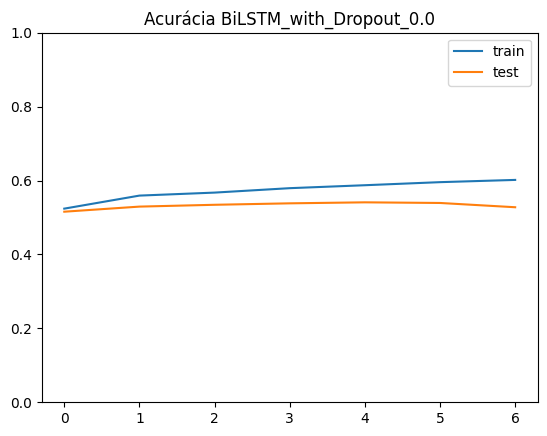

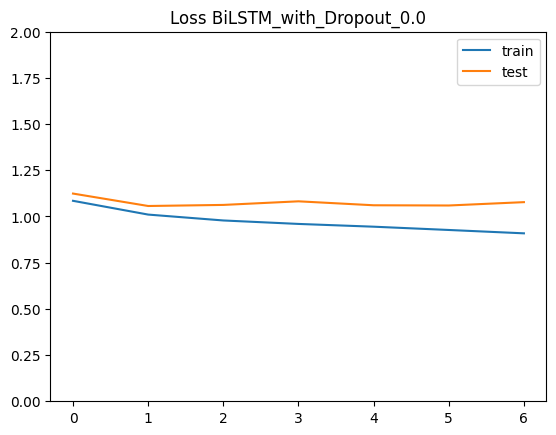

Model: "BiLSTM_with_Dropout_0.25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 64)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 64, 128)           76800     
                                                                 
 bidirectional_2 (Bidirecti  (None, 64, 256)           263168    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                          

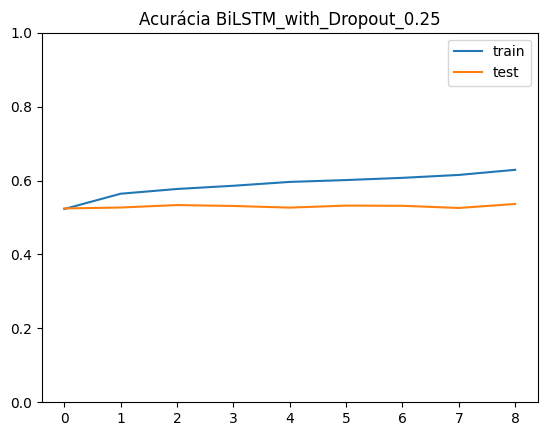

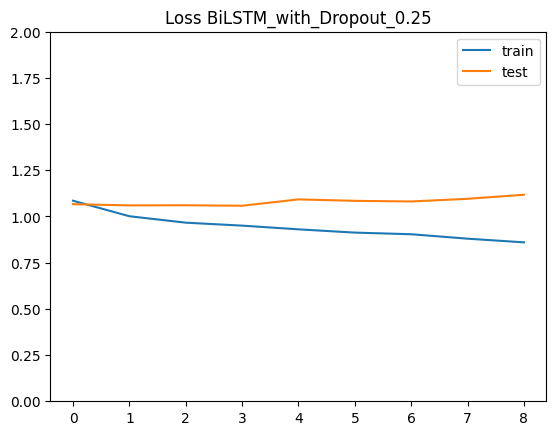

Model: "BiLSTM_with_Dropout_0.5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 64)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 64, 128)           76800     
                                                                 
 bidirectional_4 (Bidirecti  (None, 64, 256)           263168    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                           

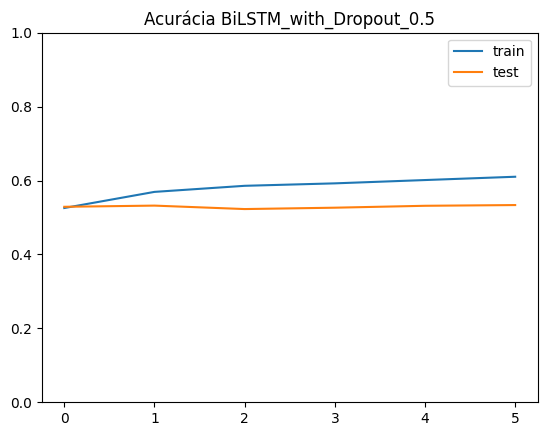

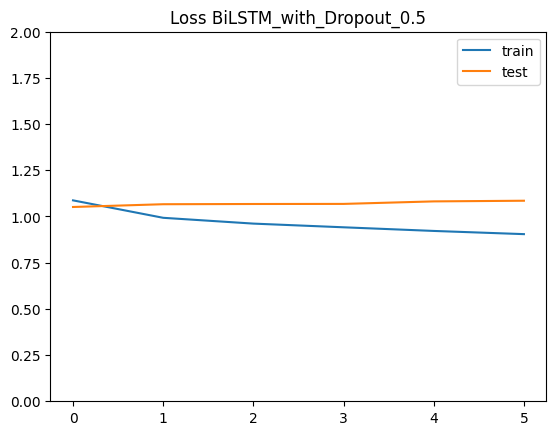

In [18]:
def prepare_model_bidirectional_lstm(vectorize_layer, embedding_layer, dropout=0.0):
    '''
    Prepara modelo com rede bidirecional LSTM.
    '''

    model = tf.keras.Sequential([

        # Pre-processamento dos dados
        tf.keras.Input(shape=(1,), dtype=tf.string),
        vectorize_layer,
        embedding_layer,

        ##############################################

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(5, activation='softmax') # 5 classes

    ], name=f'BiLSTM_with_Dropout_{str(dropout)}')

    model.summary()

    return model

################################################################################

# LSTM + Dropout=0.0
model = prepare_model_bidirectional_lstm(vectorizer, embedding_layer, dropout=0.0)
run_model(train, validation, test, model)

# LSTM + Dropout=0.25
model = prepare_model_bidirectional_lstm(vectorizer, embedding_layer, dropout=0.25)
run_model(train, validation, test, model)

# LSTM + Dropout=0.50
model = prepare_model_bidirectional_lstm(vectorizer, embedding_layer, dropout=0.50)
run_model(train, validation, test, model)


**Testes GRU + Dropout - Bidirecional**

1. GRU  + Dropout = 0
2. GRU  + Dropout = 0.25
3. GRU  + Dropout = 0.50

Model: "BiGRU_with_Dropout_0.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 64)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 64, 128)           76800     
                                                                 
 bidirectional_6 (Bidirecti  (None, 64, 256)           263168    
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                            

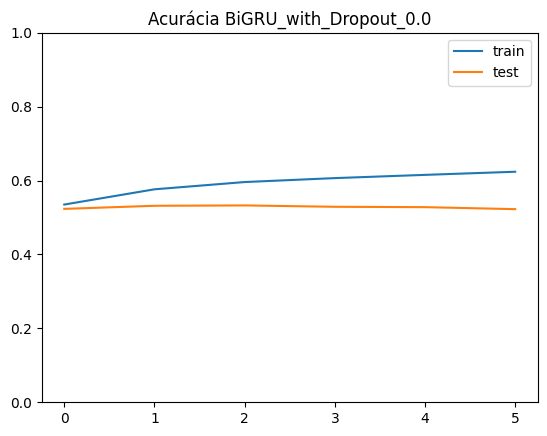

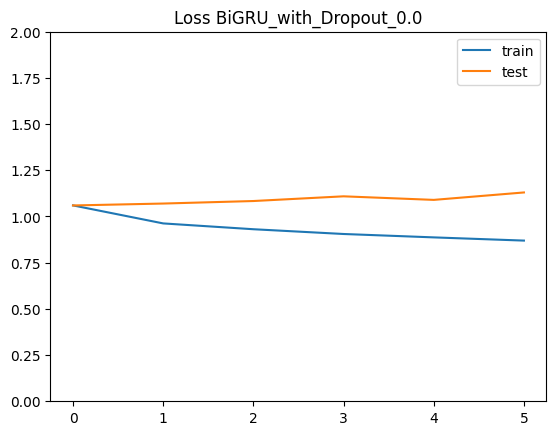

Model: "BiGRU_with_Dropout_0.25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 64)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 64, 128)           76800     
                                                                 
 bidirectional_8 (Bidirecti  (None, 64, 256)           263168    
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                           

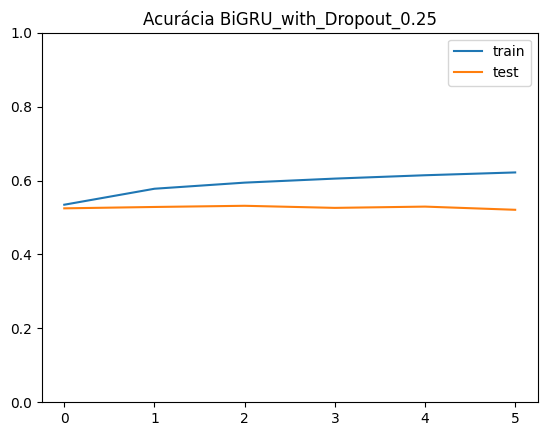

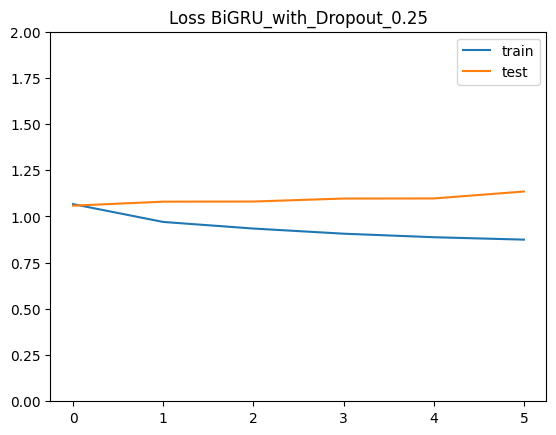

Model: "BiGRU_with_Dropout_0.5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 64)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 64, 128)           76800     
                                                                 
 bidirectional_10 (Bidirect  (None, 64, 256)           263168    
 ional)                                                          
                                                                 
 bidirectional_11 (Bidirect  (None, 128)               164352    
 ional)                                                          
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                            

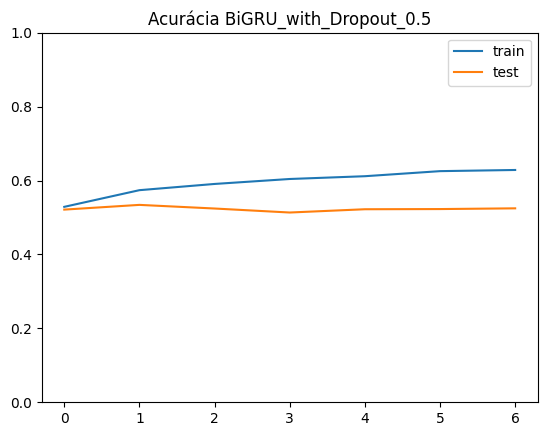

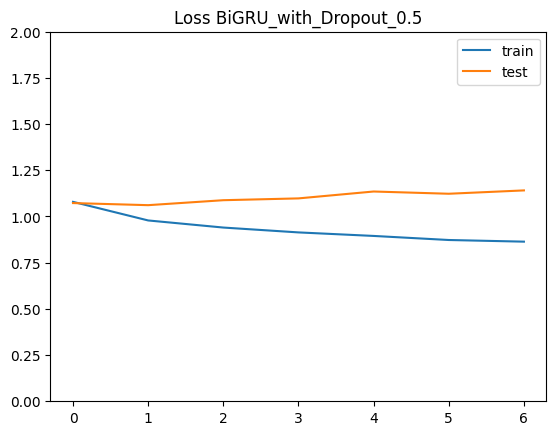

In [19]:
def prepare_model_bidirectional_gru(vectorize_layer, embedding_layer, dropout=0.0):
    '''
    Prepara modelo com rede bidirecional GRU.
    '''

    model = tf.keras.Sequential([
        # Pre-processamento dos dados
        tf.keras.Input(shape=(1,), dtype=tf.string),
        vectorize_layer,
        embedding_layer,

        ##############################################

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(5, activation='softmax') # 5 classes

    ], name=f'BiGRU_with_Dropout_{str(dropout)}')

    model.summary()

    return model

################################################################################

# GRU + Dropout=0.0
model = prepare_model_bidirectional_gru(vectorizer, embedding_layer, dropout=0.0)
run_model(train, validation, test, model)

# GRU + Dropout=0.25
model = prepare_model_bidirectional_gru(vectorizer, embedding_layer, dropout=0.25)
run_model(train, validation, test, model)

# GRU + Dropout=0.50
model = prepare_model_bidirectional_gru(vectorizer, embedding_layer, dropout=0.50)
run_model(train, validation, test, model)

## Teste com Redes Unidirecionais

**LSTM Unidirecional + Dropout**

1. LSTM + Dropout = 0
2. LSTM + Dropout = 0.25
3. LSTM + Dropout = 0.50


Model: "LSTM_with_Dropout_0.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 64)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 64, 128)           76800     
                                                                 
 lstm_6 (LSTM)               (None, 64, 128)           131584    
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                             

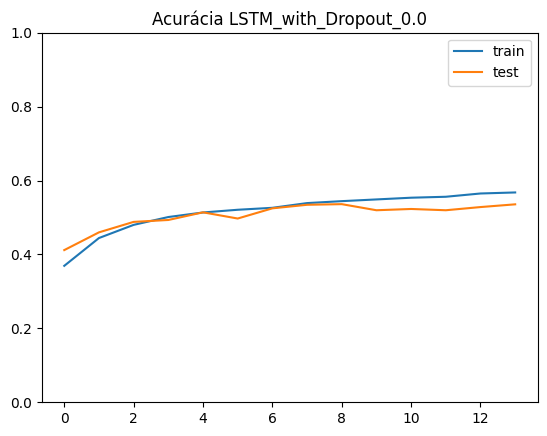

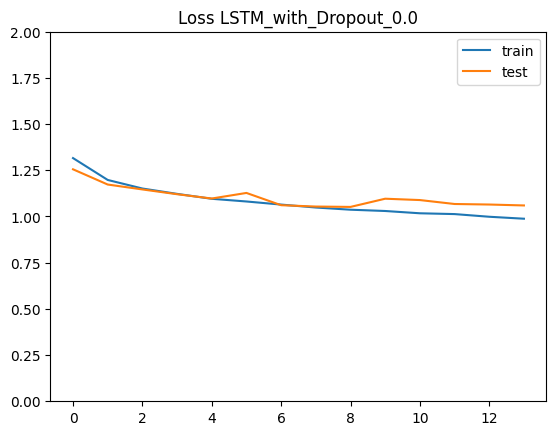

Model: "LSTM_with_Dropout_0.25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 64)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 64, 128)           76800     
                                                                 
 lstm_8 (LSTM)               (None, 64, 128)           131584    
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 5)                 325       
                                            

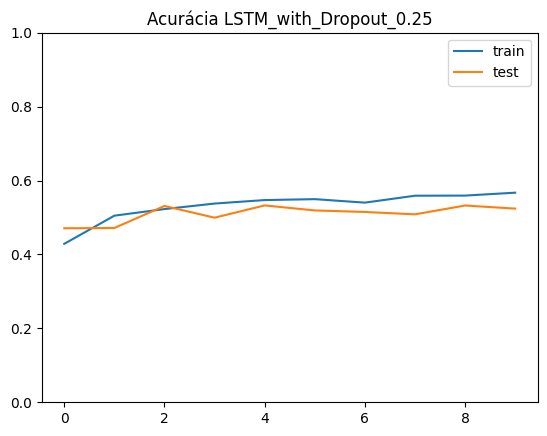

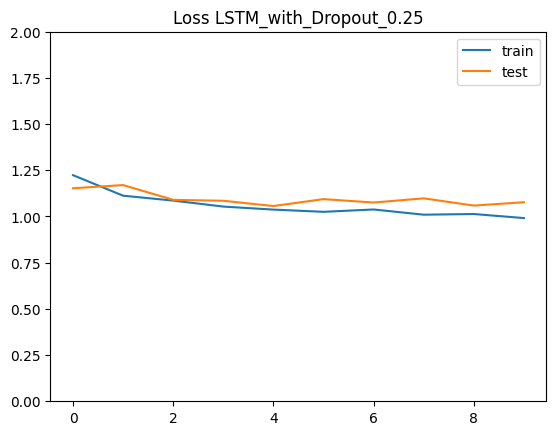

Model: "LSTM_with_Dropout_0.5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 64)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 64, 128)           76800     
                                                                 
 lstm_10 (LSTM)              (None, 64, 128)           131584    
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 5)                 325       
                                             

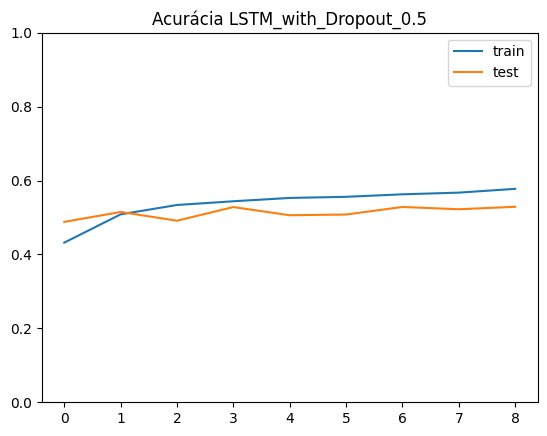

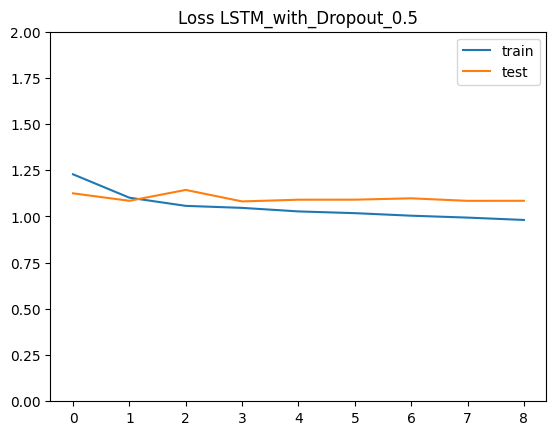

In [16]:
def prepare_model_lstm(vectorize_layer, embedding_layer, dropout=0.0):
    '''
    Prepara modelo com rede bidirecional LSTM.
    '''

    model = tf.keras.Sequential([

        # Pre-processamento dos dados
        tf.keras.Input(shape=(1,), dtype=tf.string),
        vectorize_layer,
        embedding_layer,

        ##############################################

        tf.keras.layers.LSTM(units=128, return_sequences=True),
        tf.keras.layers.LSTM(units=64),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(5, activation='softmax') # 5 classes

    ], name=f'LSTM_with_Dropout_{str(dropout)}')

    model.summary()

    return model

################################################################################

# LSTM + Dropout=0.0
model = prepare_model_lstm(vectorizer, embedding_layer, dropout=0.0)
run_model(train, validation, test, model)

# LSTM + Dropout=0.25
model = prepare_model_lstm(vectorizer, embedding_layer, dropout=0.25)
run_model(train, validation, test, model)

# LSTM + Dropout=0.50
model = prepare_model_lstm(vectorizer, embedding_layer, dropout=0.50)
run_model(train, validation, test, model)

**GRU Unidirecional + Dropout**

1. GRU  + Dropout = 0
2. GRU  + Dropout = 0.25
3. GRU  + Dropout = 0.50

Model: "GRU_with_Dropout_0.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 64)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 64, 128)           76800     
                                                                 
 gru_8 (GRU)                 (None, 64, 128)           99072     
                                                                 
 gru_9 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 5)                 325       
                                              

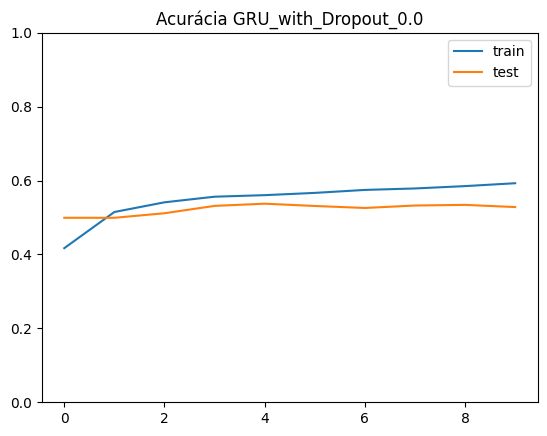

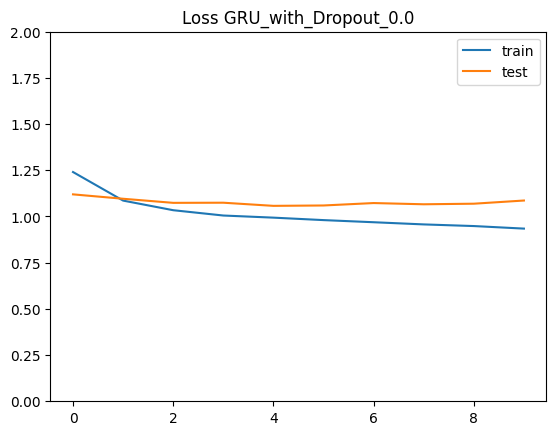

Model: "GRU_with_Dropout_0.25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 64)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 64, 128)           76800     
                                                                 
 gru_10 (GRU)                (None, 64, 128)           99072     
                                                                 
 gru_11 (GRU)                (None, 64)                37248     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 5)                 325       
                                             

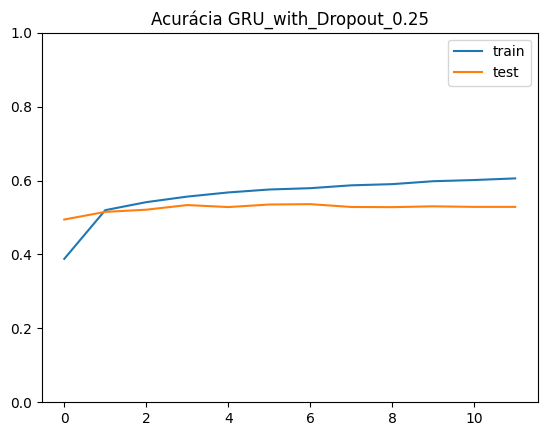

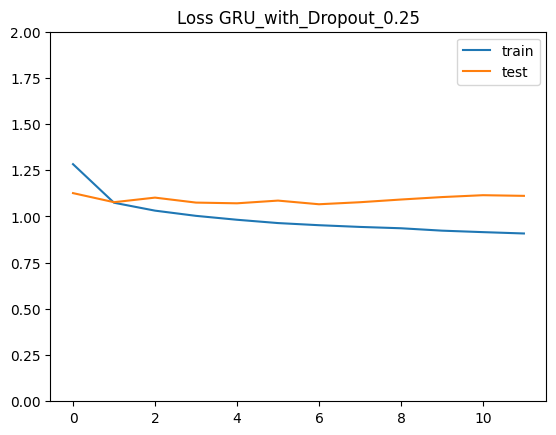

Model: "GRU_with_Dropout_0.5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 64)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 64, 128)           76800     
                                                                 
 gru_12 (GRU)                (None, 64, 128)           99072     
                                                                 
 gru_13 (GRU)                (None, 64)                37248     
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 5)                 325       
                                              

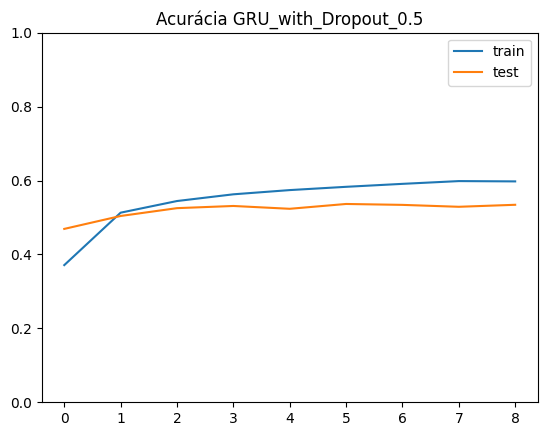

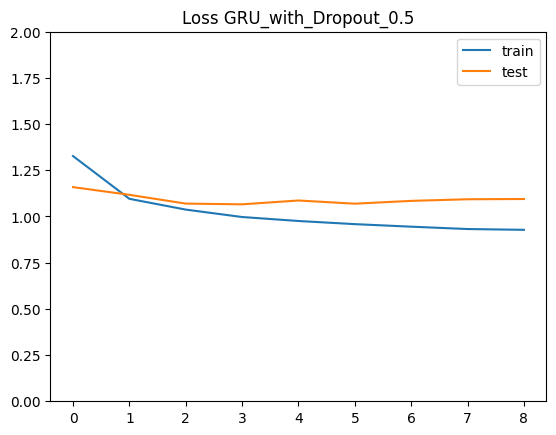

In [17]:
def prepare_model_gru(vectorize_layer, embedding_layer, dropout=0.0):
    '''
    Prepara modelo com rede bidirecional GRU.
    '''

    model = tf.keras.Sequential([
        # Pre-processamento dos dados
        tf.keras.Input(shape=(1,), dtype=tf.string),
        vectorize_layer,
        embedding_layer,

        ##############################################

        tf.keras.layers.GRU(units=128, return_sequences=True),
        tf.keras.layers.GRU(units=64),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(5, activation='softmax') # 5 classes

    ], name=f'GRU_with_Dropout_{str(dropout)}')

    model.summary()

    return model

################################################################################

# GRU + Dropout=0.0
model = prepare_model_gru(vectorizer, embedding_layer, dropout=0.0)
run_model(train, validation, test, model)

# GRU + Dropout=0.25
model = prepare_model_gru(vectorizer, embedding_layer, dropout=0.25)
run_model(train, validation, test, model)

# GRU + Dropout=0.50
model = prepare_model_gru(vectorizer, embedding_layer, dropout=0.50)
run_model(train, validation, test, model)